<a href="https://colab.research.google.com/github/JaquesZanon/JOB/blob/main/escolha_modelos_previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importando os dados

In [1]:
# Precisamos instalar algumas Bibliotecas
!pip install utils
!pip install pmdarima # para autoARIMA
!pip install pyEDM # Para Empirical Dynamic Modeling
!pip install croston
!pip install gluonts # PAra DeepAR
!pip install mxnet # PAra Deep AR
!pip install prophet
!pip install tqdm
!pip install sklearn
!pip install --upgrade mxnet~=1.7 gluonts
!pip install darts
!pip install 'u8darts[all]'


     |████████████████████████████████| 1.5 MB 8.5 MB/s 
     |████████████████████████████████| 9.5 MB 50.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 5.3 MB 6.3 MB/s 
     |████████████████████████████████| 199 kB 59.3 MB/s 
     |████████████████████████████████| 2.1 MB 7.7 MB/s 
     |████████████████████████████████| 10.1 MB 39.3 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.0 which is i

     |████████████████████████████████| 198 kB 8.3 MB/s 


In [1]:
# Importa aquivo de texto (.txt)
import pandas as pd
df_original = pd.read_csv('/content/drive/MyDrive/JOB-Martins/DadosPrevisaoDemanda.csv',sep=';', decimal=',', engine='python')

df_original['PrimeiraDataSemana'] = pd.to_datetime(df_original['PrimeiraDataSemana'])
df_original['UltimaDataSemana'] = pd.to_datetime(df_original['UltimaDataSemana'])
df_original = df_original.sort_values(by=['PrimeiraDataSemana'])
df_original.head()
df_original.shape

(183742, 16)

### Nº

In [ ]:
df_original.groupby(['DsDivisaoFornecedor'])[['CdGrupoProdutoSimilar']].nunique().mean()

CdGrupoProdutoSimilar    22.804989
dtype: float64

### Selecionando um distribuidor e um produto similar

In [ ]:
dez_mais = df_original.groupby(['DsDivisaoFornecedor'])['VlTotalBruto'].sum().sort_values(ascending=False)


In [2]:
#dat_aux = pd.DataFrame(df_reduzido.groupby(['DsDivisaoFornecedor'])['CdGrupoProdutoSimilar'].unique())
dat_aux = pd.DataFrame(df_original.groupby(['DsDivisaoFornecedor'])['CdGrupoProdutoSimilar'].unique())
dat_aux

,CdGrupoProdutoSimilar
DsDivisaoFornecedor,
3M DO BRASIL LTDA,"[805, 97145, 803, 88, 818, 97147, 406632, 9714..."
3M DO BRASIL LTDA - DIV. FITAS,"[406207, 400433, 229, 406675, 406674, 400434, ..."
3M DO BRASIL LTDA - EPI,"[9000524, 9000527, 9000531]"
3M DO BRASIL LTDA - LIMPEZA,"[1700717, 1704060, 1702339, 200755, 203136, 20..."
3M DO BRASIL LTDA LIMPEZA &&MP,"[1702629, 1701347, 1701348, 1701261, 1701262, ..."
...,...
WHIRLPOOL S.A - L.BCA,"[636, 1041, 191, 2217224, 1793, 1794, 2213230,..."
WORLD COM IND MED VET COSM LIM,"[701869, 701761, 701768, 701767, 701762, 70176..."
WOW INDUSTRIA E COMERCIO LTDA,"[1600715, 1600716, 1600609, 1600455, 1600390, ..."


In [3]:
from scipy import stats
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import r2_score
from croston import croston
from prophet import Prophet
from tqdm import tqdm
import time
import pyEDM

### Função Men absolute percentage error

In [183]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [27]:
filter1 = df_original["DsDivisaoFornecedor"]=='MACROPLASTIC IND E COM.EMBALAG.&&MP'
df_0 = df_original[filter1]
df = df_0.groupby(['Semanas'])[['VlTotalBruto']].sum()
we = pd.DataFrame(list(range(1,65,1)))
we.columns=['Semanas']
we.index=we.Semanas
df = pd.concat([df, we], axis=1)
df=df['VlTotalBruto']
df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
df = pd.DataFrame(df).fillna(0)
#df = df.reset_index()
#pd.DataFrame(df).to_csv('/content/drive/MyDrive/JOB-Martins/BLACK & DECKER ELETRODOMESTICOS.csv')

In [ ]:
df

,date,VlTotalBruto
0,2020-01-05,257.80
1,2020-01-12,2201.57
2,2020-01-19,2181.26
3,2020-01-26,2457.43
4,2020-02-02,1194.74
...,...,...
59,2021-02-21,13933.60
60,2021-02-28,6458.10
61,2021-03-07,5057.55
62,2021-03-14,8871.78


In [5]:
from darts import TimeSeries

In [ ]:
series = TimeSeries.from_dataframe(df, 'date', 'VlTotalBruto')
series

In [ ]:
train, val = series.split_after(0.7)

In [ ]:
pip install delayed

     |████████████████████████████████| 72 kB 508 kB/s 
     |████████████████████████████████| 85 kB 3.9 MB/s 


In [ ]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Text(0.5, 0, 'Year')

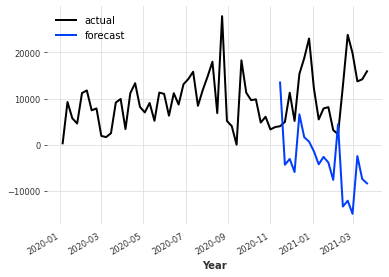

In [ ]:
import matplotlib.pyplot as plt

series.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year')

In [ ]:
import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihoodModel
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt


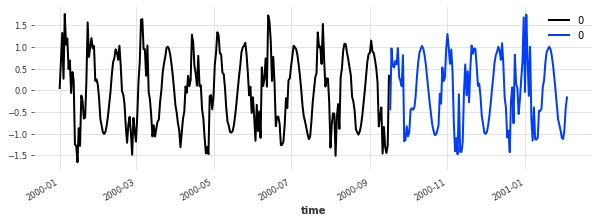

In [ ]:
length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (
    tg.sine_timeseries(length=length, value_frequency=0.02) 
    + tg.constant_timeseries(length=length, value=1)) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

plt.figure(figsize=(10, 3))
target_train.plot()
target_val.plot()


In [ ]:
deeptcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=20,
    kernel_size=2,
    num_filters=4,
    dilation_base=2,
    dropout=0,
    random_state=0,
    likelihood=GaussianLikelihoodModel())
deeptcn.fit(target_train, covariates, verbose=True)

  2%|▏         | 2/100 [00:00<00:12,  7.63it/s]

 12%|█▏        | 12/100 [00:01<00:10,  8.38it/s]

 22%|██▏       | 22/100 [00:02<00:09,  8.50it/s]

 32%|███▏      | 32/100 [00:03<00:08,  8.50it/s]

 42%|████▏     | 42/100 [00:05<00:06,  8.31it/s]

 52%|█████▏    | 52/100 [00:06<00:06,  7.97it/s]

 62%|██████▏   | 62/100 [00:07<00:04,  8.30it/s]

 72%|███████▏  | 72/100 [00:08<00:03,  8.45it/s]

 82%|████████▏ | 82/100 [00:09<00:02,  8.50it/s]

 92%|█████████▏| 92/100 [00:11<00:00,  8.48it/s]

100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


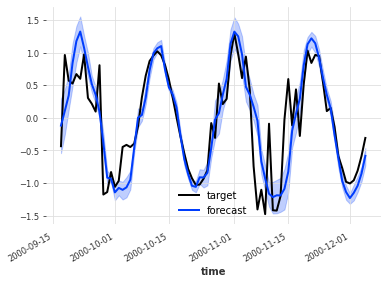

In [ ]:
pred = deeptcn.predict(80, covariates=covariates, num_samples=100)
target_val.slice_intersect(pred).plot(label='target')
pred.plot(label='forecast')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [ ]:
series_sunspot = SunspotsDataset().load()
series_sunspot = series
scaler = Scaler()
series_sp_transformed = scaler.fit_transform(series_sunspot)

# series_sunspot = series_sunspot.add_datetime_attribute('month', True)
train_sp_transformed, val_sp_transformed = series_sp_transformed.split_after(0.7)

In [ ]:
model_sun = TCNModel(
    input_chunk_length=12,
    output_chunk_length=2,
    n_epochs=100,
    dropout=0,
    dilation_base=1,
    weight_norm=True,
    kernel_size=3,
    num_filters=3,
    nr_epochs_val_period=10,
    random_state=0
)

In [ ]:
model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

 11%|█         | 11/100 [00:00<00:01, 51.28it/s]

 29%|██▉       | 29/100 [00:00<00:01, 51.82it/s]

 41%|████      | 41/100 [00:00<00:01, 51.06it/s]

 59%|█████▉    | 59/100 [00:01<00:00, 54.50it/s]

 77%|███████▋  | 77/100 [00:01<00:00, 53.77it/s]

100%|██████████| 100/100 [00:01<00:00, 52.39it/s]

In [ ]:
pred = model_sun.predict(n=20, series=val_sp_transformed)

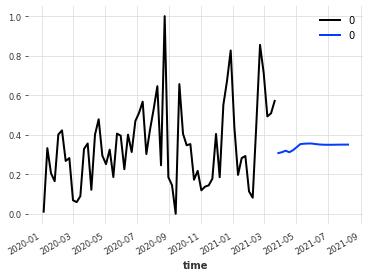

In [ ]:
series_sp_transformed.plot()
pred.plot()

In [ ]:
pred = model_sun.predict(n=20, series=val_sp_transformed)

In [ ]:
pred

In [ ]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=10,
    dropout=0,
    batch_size=10,
    n_epochs=50,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    training_length=40,
    input_chunk_length=10,
    likelihood=GaussianLikelihoodModel()
)
my_model.fit(train, verbose=True)

 32%|███▏      | 16/50 [00:00<00:00, 75.96it/s]

 64%|██████▍   | 32/50 [00:00<00:00, 71.42it/s]

100%|██████████| 50/50 [00:00<00:00, 72.05it/s]

In [ ]:
pred = my_model.predict(n=20, series=train)

100.0018363508147


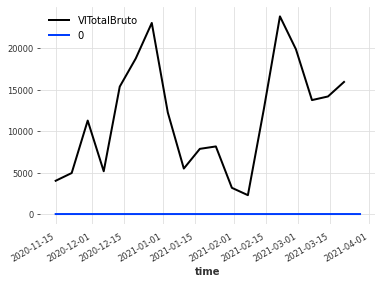

In [ ]:
val.plot()
pred.plot()
print(mape(val, pred))

In [ ]:
models = [NaiveDrift(),
    Prophet(weekly_seasonality=True),
    ExponentialSmoothing(),
    Theta(),
    FFT(trend='poly',trend_poly_degree = 3),
    
]

for model in models:
    model.fit(train+0.00000001)
    pred_val = model.predict(len(val))
    print(str(model) + " MAPE: " + str(mape(pred_val, val)))

Naive drift model MAPE: 159.05897358685667
Prophet MAPE: 48.75968806416458
Exponential smoothing MAPE: 500.3727538293682
Theta(2) MAPE: 110.55084454879889
FFT(nr_freqs_to_keep=10, trend=poly) MAPE: 339.5617529588956
<darts.models.tcn_model.TCNModel object at 0x7f0d02cbe710> MAPE: 201.04889452117146


In [ ]:
par={}
erro={}
par_croston={}
erro_croston={}
erro_prophet={}
erro_EDM = {}

#for j, i in zip(tqdm (range(0, 7),desc="Processando Fornecedor", ascii=False, ncols=75), tqdm (range(0,len(dat_aux.iloc[j,0])),desc="Processando Id Oriduto", ascii=False, ncols=75)):

for j in tqdm (range(0, 1),desc="Processando Fornecedor", ascii=False, ncols=75):
  
    try:
   # Selecionando os dados para ajustar os modelos
         filter1 = df_original["DsDivisaoFornecedor"]==dat_aux.index[j]
         #filter1 = df_original["DsDivisaoFornecedor"]=='SAINT GOBAIN DO BRASIL PRODUTOS IND'
         df_0 = df_original[filter1]
         df = df_0.groupby(['Semanas'])[['VlTotalBruto']].sum()
         we = pd.DataFrame(list(range(1,65,1)))
         we.columns=['Semanas']
         we.index=we.Semanas
         df = pd.concat([df, we], axis=1)
         df=df['VlTotalBruto']
         df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
         df = pd.DataFrame(df).fillna(0)

      # Substituindo outliers
         z = np.abs(stats.zscore(df.VlTotalBruto))
         median=df.VlTotalBruto.median()
         df["VlTotalBruto"] = np.where(z>3, median, df["VlTotalBruto"])

      # Sets de treino e teste
         train_len = int(df.shape[0] * 0.7)
         train_data, test_data = df[:train_len], df[train_len:]

      # Ajustando AutoArima
         stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
   
      # Armazenando resultados AutoArima
         sentence = [str(dat_aux.index[j])]
         sentence = '-'.join(sentence)
         aux = stepwise_fit.get_params()
         par[sentence]=aux
         forecasts = stepwise_fit.predict(test_data.shape[0])
         mmae = mean_absolute_percentage_error(list(list(test_data.VlTotalBruto)), list(forecasts))
         erro[sentence]=mmae
         erro
  
      # Ajustando modelo Croston
         croston_pred = croston.fit_croston(df+0.000001,test_data.shape[0],'original')

      # Armazenando resultados Croston
         par_croston[sentence] = croston_pred
         erro_croston[sentence] = mean_absolute_percentage_error(list(test_data.VlTotalBruto), croston_pred['croston_forecast'])

      # O modelo profet só funciona com duas colunas
         y = df.reset_index(drop=False)
         y.columns = ['ds', 'y']
         #y['floor'] = 0
         #y['cap'] = 200000
         train = y.iloc[:train_data.shape[0],:]
         test = y.iloc[train_data.shape[0]:,:]

      #Ajustando modelo Prophet
         m = Prophet(weekly_seasonality = True,
                     yearly_seasonality = False,
                     daily_seasonality = False)
         m.fit(train, verbose=0)
         future = m.make_future_dataframe(periods=len(test))
         future['ds'] = pd.to_datetime(future['ds']).dt.date
         forecast = m.predict(future)
         one=test['y']
         twi=list(forecast.loc[:test_data.shape[0]-1,'yhat'])
         erro_prophet[sentence] = mean_absolute_percentage_error(list(one),list(twi))
         

         # O EDM agora, preparando o imput
         y = y[["ds","y"]]
         y.columns = ["Time", "Revenue"]
         y.Time = list(range(1,df.shape[0]+1,1))
         aaa=pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue",showPlot=False)
         maxE = aaa.rho.max()
         selectedE=aaa[aaa.rho==maxE]['E']
         #bbb=pyEDM.PredictInterval(dataFrame = y,lib="1 44", pred="45 64", columns="Revenue", E=selectedE, showPlot=False)
         simplex_pred = pyEDM.Simplex(dataFrame = y,lib="1 44", pred="45 64", E= 1 if maxE==0 else selectedE, columns="Revenue",Tp=4,tau=1)
         #print(pyEDM.ComputeError(simplex_pred['Observations'],simplex_pred['Predictions']))
         simplex_pred = simplex_pred[['Observations','Predictions']].dropna()
         erro_EDM[sentence] = mean_absolute_percentage_error(list(simplex_pred['Observations']), list(simplex_pred['Predictions']))
    except:
      pass   

#pd.DataFrame.from_dict(erro_prophet,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/prophet.csv')
#pd.DataFrame.from_dict(erro_croston,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/croston.csv')
#pd.DataFrame.from_dict(erro,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/arima.csv')
#pd.DataFrame.from_dict(erro_EDM,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/EDM.csv')
print('Cmplete')

In [ ]:
forecasts = stepwise_fit.predict(test_data.shape[0])
forecasts

array([ 1978.029548  ,  2025.58811445,   886.14857419,  6122.97824549,
        5490.78007915,  4776.00687645,  9057.79692678, 10602.96884963,
        5574.70263461,  5050.61202604,  7214.50283506,  5252.87460786,
        6142.62235104,  6528.82587912,  2448.74739578,  5874.61459931,
        3253.73227237, 10453.99435792,  9960.90255245, 10741.3407695 ])

### Código para todas as analises dos fornecedores

In [ ]:
par={}
erro={}
par_croston={}
erro_croston={}
erro_prophet={}
erro_EDM = {}

#for j, i in zip(tqdm (range(0, 7),desc="Processando Fornecedor", ascii=False, ncols=75), tqdm (range(0,len(dat_aux.iloc[j,0])),desc="Processando Id Oriduto", ascii=False, ncols=75)):

for j in tqdm (range(0, 1),desc="Processando Fornecedor", ascii=False, ncols=75):
  
    try:
   # Selecionando os dados para ajustar os modelos
         filter1 = df_original["DsDivisaoFornecedor"]==dat_aux.index[j]
         #filter1 = df_original["DsDivisaoFornecedor"]=='SAINT GOBAIN DO BRASIL PRODUTOS IND'
         df_0 = df_original[filter1]
         df = df_0.groupby(['Semanas'])[['VlTotalBruto']].sum()
         we = pd.DataFrame(list(range(1,65,1)))
         we.columns=['Semanas']
         we.index=we.Semanas
         df = pd.concat([df, we], axis=1)
         df=df['VlTotalBruto']
         df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
         df = pd.DataFrame(df).fillna(0)

      # Substituindo outliers
         z = np.abs(stats.zscore(df.VlTotalBruto))
         median=df.VlTotalBruto.median()
         df["VlTotalBruto"] = np.where(z>3, median, df["VlTotalBruto"])

      # Sets de treino e teste
         train_len = int(df.shape[0] * 0.7)
         train_data, test_data = df[:train_len], df[train_len:]

      # Ajustando AutoArima
         stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
   
      # Armazenando resultados AutoArima
         sentence = [str(dat_aux.index[j])]
         sentence = '-'.join(sentence)
         aux = stepwise_fit.get_params()
         par[sentence]=aux
         forecasts = stepwise_fit.predict(test_data.shape[0])
         mmae = mean_absolute_percentage_error(list(list(test_data.VlTotalBruto)), list(forecasts))
         erro[sentence]=mmae
         erro
  
      # Ajustando modelo Croston
         croston_pred = croston.fit_croston(df+0.000001,test_data.shape[0],'original')

      # Armazenando resultados Croston
         par_croston[sentence] = croston_pred
         erro_croston[sentence] = mean_absolute_percentage_error(list(test_data.VlTotalBruto), croston_pred['croston_forecast'])

      # O modelo profet só funciona com duas colunas
         y = df.reset_index(drop=False)
         y.columns = ['ds', 'y']
         #y['floor'] = 0
         #y['cap'] = 200000
         train = y.iloc[:train_data.shape[0],:]
         test = y.iloc[train_data.shape[0]:,:]

      #Ajustando modelo Prophet
         m = Prophet(weekly_seasonality = True,
                     yearly_seasonality = False,
                     daily_seasonality = False)
         m.fit(train, verbose=0)
         future = m.make_future_dataframe(periods=len(test))
         future['ds'] = pd.to_datetime(future['ds']).dt.date
         forecast = m.predict(future)
         one=test['y']
         twi=list(forecast.loc[:test_data.shape[0]-1,'yhat'])
         erro_prophet[sentence] = mean_absolute_percentage_error(list(one),list(twi))
         

         # O EDM agora, preparando o imput
         y = y[["ds","y"]]
         y.columns = ["Time", "Revenue"]
         y.Time = list(range(1,df.shape[0]+1,1))
         aaa=pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue",showPlot=False)
         maxE = aaa.rho.max()
         selectedE=aaa[aaa.rho==maxE]['E']
         #bbb=pyEDM.PredictInterval(dataFrame = y,lib="1 44", pred="45 64", columns="Revenue", E=selectedE, showPlot=False)
         simplex_pred = pyEDM.Simplex(dataFrame = y,lib="1 44", pred="45 64", E= 1 if maxE==0 else selectedE, columns="Revenue",Tp=4,tau=1)
         #print(pyEDM.ComputeError(simplex_pred['Observations'],simplex_pred['Predictions']))
         simplex_pred = simplex_pred[['Observations','Predictions']].dropna()
         erro_EDM[sentence] = mean_absolute_percentage_error(list(simplex_pred['Observations']), list(simplex_pred['Predictions']))
    except:
      pass   

#pd.DataFrame.from_dict(erro_prophet,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/prophet.csv')
#pd.DataFrame.from_dict(erro_croston,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/croston.csv')
#pd.DataFrame.from_dict(erro,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/arima.csv')
#pd.DataFrame.from_dict(erro_EDM,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/EDM.csv')
print('Cmplete')

Processando Fornecedor: 100%|████████████████| 1/1 [00:21<00:00, 21.80s/it]

Cmplete


In [ ]:

aa = pd.DataFrame(simplex_pred[['Observations','Predictions']])
aa # EDM

s1 = pd.DataFrame(test['y']).reset_index()
s2 = pd.DataFrame(twi).reset_index()
bb = pd.concat([s1.iloc[:,1],s2.iloc[:,1]],axis=1)
bb # Prophet


s3 = pd.DataFrame(test_data.VlTotalBruto).reset_index()
s4 = pd.DataFrame(croston_pred['croston_forecast']).reset_index()
cc = pd.concat([s3.iloc[:,1],s4.iloc[:,1]],axis=1)
cc # Croston


s5 = pd.DataFrame(test_data.VlTotalBruto).reset_index()
s6 = pd.DataFrame(forecasts).reset_index()
dd= pd.concat([s5.iloc[:,1],s6.iloc[:,1]],axis=1)
dd  # ARIMA

final = pd.concat([aa.iloc[:,1],bb.iloc[:,1],cc.iloc[:,1],dd.iloc[:,1]], axis=1)
final.columns = ['EDM','Prophet','Croston','ARIMA']
final.to_csv('/content/drive/MyDrive/JOB-Martins/SAINT GOBAIN DO BRASIL PRODUTOS IND2.csv')

In [ ]:
erro, erro_prophet, erro_croston,erro_EDM

({'3M DO BRASIL LTDA': 116.60686633359414,
  '3M DO BRASIL LTDA - DIV. FITAS': 68.63434119378883},
 {'3M DO BRASIL LTDA': 71.22382022704589,
  '3M DO BRASIL LTDA - DIV. FITAS': 47.50531076880594},
 {'3M DO BRASIL LTDA': 80.63675939470585,
  '3M DO BRASIL LTDA - DIV. FITAS': 92.89398160955729},
 {'3M DO BRASIL LTDA': 142.3757750317709,
  '3M DO BRASIL LTDA - DIV. FITAS': 73.53776328416313})

In [ ]:
# Para todos od produtos

par={}
erro={}
par_croston={}
erro_croston={}
erro_prophet={}



for j in range(0, 7):
      for i in range(0,len(dat_aux.iloc[j,0])):
   # Selecionando os dados para ajustar os modelos
         filter1 = df_reduzido["DsDivisaoFornecedor"]==dat_aux.index[j]
         filter2 = df_reduzido['CdGrupoProdutoSimilar']==dat_aux.iloc[j,0][i]
         df_0 = df_reduzido[filter1 & filter2]
         df = df_0.groupby(['Semanas'])[['QtdeVendida']].sum()
         we = pd.DataFrame(list(range(1,65,1)))
         we.columns=['Semanas']
         we.index=we.Semanas
         df = pd.concat([df, we], axis=1)
         df=df['QtdeVendida']
         df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
         df = pd.DataFrame(df).fillna(0)

      # Substituindo outliers
         z = np.abs(stats.zscore(df.QtdeVendida))
         median=df.QtdeVendida.median()
         df["QtdeVendida"] = np.where(z>3, median, df["QtdeVendida"])

      # Sets de treino e teste
         train_len = int(df.shape[0] * 0.7)
         train_data, test_data = df[:train_len], df[train_len:]

      # Ajustando AutoArima
         stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
   
      # Armazenando resultados AutoArima
         sentence = [str(dat_aux.index[j]) , str(dat_aux.iloc[j,0][i])]
         sentence = '-'.join(sentence)
         aux = stepwise_fit.get_params()
         par[sentence]=aux
         forecasts = stepwise_fit.predict(test_data.shape[0])  # predict N steps into the future
         mmae = mean_absolute_error(test_data, forecasts)
         erro[sentence]=mmae
  
      # Ajustando modelo Croston
         croston_pred = croston.fit_croston(df+0.000001,test_data.shape[0],'original')

      # Armazenando resultados Croston
         par_croston[sentence]=croston_pred
         erro_croston[sentence] = mean_absolute_error(test_data, croston_pred['croston_forecast'])

      # O modelo profet só funciona com duas colunas
         y = df.reset_index(drop=False)
         y.columns = ['ds', 'y']
         y['floor'] = 0
         y['cap'] = 2000
         train = y.iloc[:train_data.shape[0],:]
         test = y.iloc[train_data.shape[0]:,:]

      #Ajustando modelo Prophet
         m = Prophet(weekly_seasonality = True,
                     yearly_seasonality = False,
                     daily_seasonality = False)
         m.fit(train, verbose=0)
         future = m.make_future_dataframe(periods=len(test))
         future['ds'] = pd.to_datetime(future['ds']).dt.date
         forecast = m.predict(future)
         erro_prophet[sentence] = mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))
         
        import tqdm
        import time

       for i in tqdm.tqdm(range(1000)):
       time.sleep(0.01)




pd.DataFrame.from_dict(erro_prophet,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/prophet.csv')
pd.DataFrame.from_dict(erro_croston,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/croston.csv')
pd.DataFrame.from_dict(erro,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/arima.csv')

###Miscellanious
Ajustes em Geral dos Modelos

In [ ]:
resultado = {}
df_2 = df
for j in range(0, 441):
   filter1 = df_original["DsDivisaoFornecedor"]==dat_aux.index[j]
   df_0 = df_original[filter1]
   df = df_0.groupby(['Semanas'])[['VlTotalBruto']].sum()
   we = pd.DataFrame(list(range(1,65,1)))
   we.columns=['Semanas']
   we.index=we.Semanas
   df = pd.concat([df, we], axis=1)
   df=df['VlTotalBruto']
   df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
   df = pd.DataFrame(df).fillna(0)
   df.columns = [dat_aux.index[j]]
   df_2[dat_aux.index[j]]=df
   #resultado[dat_aux.index[j]] = df.reset_index()


   

In [ ]:
df_2.to_csv('/content/drive/MyDrive/JOB-Martins/lista_todos.csv')

In [ ]:
df

,ZOETIS IND.PROD.VETERINARIOS LTDA
date,
2020-01-05,4379.48
2020-01-12,26184.72
2020-01-19,31220.32
2020-01-26,25313.68
2020-02-02,21667.41
...,...
2021-02-21,80155.77
2021-02-28,55338.84
2021-03-07,42127.12


In [ ]:
# O modelo profet só funciona com duas colunas
y = df.reset_index(drop=False)
y.columns = ['ds', 'y']
y['floor'] = 0
y['cap'] = 2000
train = y.iloc[:train_data.shape[0],:]
test = y.iloc[train_data.shape[0]:,:]

In [ ]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=len(test))
future['ds'] = pd.to_datetime(future['ds']).dt.date
forecast = m.predict(future)
mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))

In [ ]:
m.fit(train)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=len(test))
future['ds'] = pd.to_datetime(future['ds']).dt.date
forecast = m.predict(future)
mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))

1.9036096749922158

### Instalando algumas Biblioecas

In [ ]:
# Precisamos instalar algumas Bibliotecas
!pip install utils
!pip install pmdarima # para autoARIMA
!pip install pyEDM # Para Empirical Dynamic Modeling
!pip install croston
!pip install gluonts # PAra DeepAR
!pip install mxnet # PAra Deep AR

### Ralace Outliers with median

In [ ]:
df

,QtdeVendida
date,
2020-01-05,0.0
2020-01-12,0.0
2020-01-19,0.0
2020-01-26,0.0
2020-02-02,0.0
...,...
2021-02-21,0.0
2021-02-28,32.0
2021-03-07,0.0


In [ ]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df.QtdeVendida))
#threshold = 3
print(np.where(z > 3))
median=df.QtdeVendida.median()
df["QtdeVendida"] = np.where(z>3, median, df["QtdeVendida"])


AttributeError: ignored

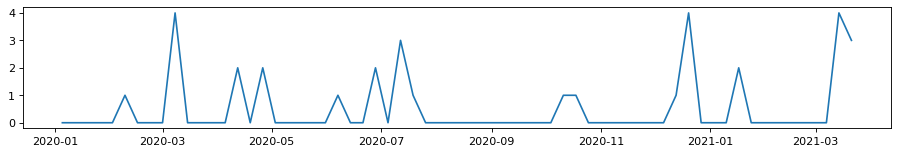

In [ ]:
# Figura Geral
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

figure(figsize=(14, 2), dpi=80)
plt.plot(df)
plt.show()

### Separando Treino e Teste

In [ ]:
train_len = int(df.shape[0] * 0.7)
train_data, test_data = df[:train_len], df[train_len:]
print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

44 train samples
20 test samples


In [ ]:
#stepwise_fit.summary()
par = stepwise_fit.get_params()
par = pd.DataFrame.from_dict(par,orient='index')
par.columns = [dat_aux.iloc[0,0][0]]
par.insert(1, dat_aux.iloc[0,0][1], par)

,805,97145
maxiter,50,50
method,lbfgs,lbfgs
order,"(1, 1, 1)","(1, 1, 1)"
out_of_sample_size,0,0
scoring,mse,mse
scoring_args,{},{}
seasonal_order,"(2, 1, 1, 12)","(2, 1, 1, 12)"
start_params,None,None
suppress_warnings,True,True
trend,None,None


In [ ]:
import pmdarima as pm
#fitting a stepwise model:
stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=140.066, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=117.245, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=120.299, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=108.716, Time=0.53 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=106.664, Time=0.62 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(

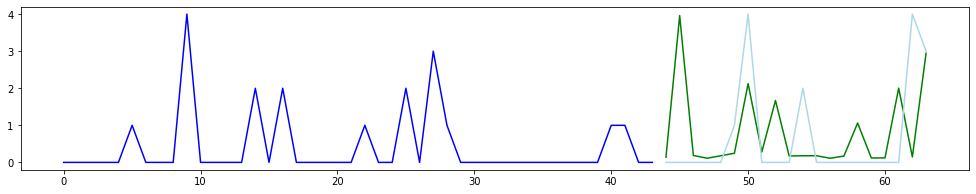

0.9413967601176487


In [ ]:
from sklearn.metrics import mean_absolute_error
# make your forecasts to test data
forecasts = stepwise_fit.predict(test_data.shape[0])  # predict N steps into the future

x = np.arange(df.shape[0])
plt.figure(figsize=(17,3))
plt.plot(x[:train_data.shape[0]], train_data, c='blue')
plt.plot(x[train_data.shape[0]:], forecasts, c='green')
plt.plot(x[train_data.shape[0]:], test_data, c='lightblue')
plt.show()
print(mean_absolute_error(test_data, forecasts))

### Modelo Croston

In [ ]:
from croston import croston

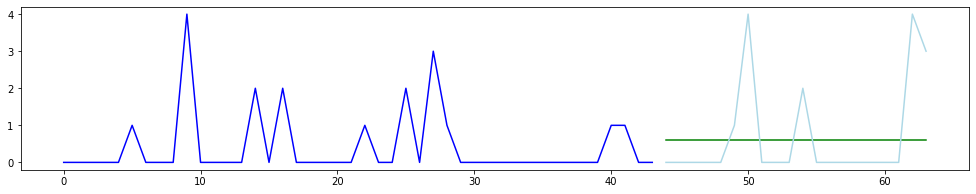

0.9989402050266951


In [ ]:
fit_pred = croston.fit_croston(df,test_data.shape[0],'original')

x = np.arange(df.shape[0])
plt.figure(figsize=(17,3))
plt.plot(x[:train_data.shape[0]], train_data, c='blue')
plt.plot(x[train_data.shape[0]:], fit_pred['croston_forecast'], c='green')
plt.plot(x[train_data.shape[0]:], test_data, c='lightblue')
plt.show()
print(mean_absolute_error(test_data, fit_pred['croston_forecast']))

### Modelo Prophet

In [ ]:
df

,ds,y,floor,cap
0,2020-01-05,305.06,0,2000
1,2020-01-12,9252.94,0,2000
2,2020-01-19,5717.31,0,2000
3,2020-01-26,4594.89,0,2000
4,2020-02-02,11182.80,0,2000
...,...,...,...,...
59,2021-02-21,23809.12,0,2000
60,2021-02-28,19842.03,0,2000
61,2021-03-07,13726.53,0,2000
62,2021-03-14,14162.61,0,2000


In [28]:
# O modelo profet só funciona com duas colunas
y = df.reset_index(drop=False)
y.columns = ['ds', 'y']
#y['floor'] = 0
#y['cap'] = 2000
train = y.iloc[:train_data.shape[0],:]
test = y.iloc[train_data.shape[0]:,:]

NameError: ignored

In [ ]:
# Função para o grid search
def model_test(holidays, weekly_seasonality,yearly_seasonality, add_monthly, add_reserve, changepoint_prior_scale, holidays_prior_scale, month_fourier):
    m = Prophet(
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            holidays=holidays,
            changepoint_prior_scale=changepoint_prior_scale,
            holidays_prior_scale=holidays_prior_scale)
    if add_monthly:
        m.add_seasonality(
            name='monthly',
            period=7,
            fourier_order=month_fourier)
    if add_reserve:
        m.add_regressor('reserve_visitors')
    m.fit(train)
    future = m.make_future_dataframe(periods=len(test))
    future['ds'] = pd.to_datetime(future['ds']).dt.date
    if add_reserve:
        future = future.merge(
            X_reservations,
            left_on = 'ds',
            right_on = 'visit_date',
            how = 'left')
        future = future[['ds', 'reserve_visitors']]
        future = future.fillna(0)
    forecast = m.predict(future)

    return mean_absolute_error(list(test['y']),list(forecast.loc[:test_data.shape[0]-1,'yhat'] ))

In [ ]:
# Setting the grid
growth = ['logistic']
holidays_opt = [None]
weekly_seas = ["auto"]
yearly_seas = ["auto"]
add_monthly = [False]
add_reserve = [False]
changepoint_prior_scale = [ 0.3, 0.5]
holidays_prior_scale = [0.3, 0.5]
month_fourier = [10]

In [ ]:
# Looping through the grid
from fbprophet import Prophet
from sklearn.metrics import r2_score
grid_results = []

for h in holidays_opt:
  for w in weekly_seas:
    for ys in yearly_seas:
      for m in add_monthly:
        for r in add_reserve:
          for c in changepoint_prior_scale:
            for hp in holidays_prior_scale:
              for mf in month_fourier:
                r2=model_test(h,w,ys,m,r,c,hp,mf)
                print([h,w,ys,m,r,c,hp,mf,r2])
                grid_results.append([h,w,ys,m,r,c,hp,mf,r2])
# adding it all to a dataframe and extract the best model
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(8, ascending=False)
h, w,ys, m, r, c,hp,mf,r2 = list(benchmark.iloc[0,:])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[None, 'auto', 'auto', False, False, 0.3, 0.3, 10, 0.9280640532677952]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[None, 'auto', 'auto', False, False, 0.3, 0.5, 10, 0.9280640532677952]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[None, 'auto', 'auto', False, False, 0.5, 0.3, 10, 0.926632490406585]
[None, 'auto', 'auto', False, False, 0.5, 0.5, 10, 0.926632490406585]


In [ ]:
m = Prophet(
            yearly_seasonality=ys,
            weekly_seasonality=w,
            holidays=h,
            changepoint_prior_scale=c,
            holidays_prior_scale=hp)
if m:
    m.add_seasonality(
            name='monthly',
            period=7,
            fourier_order=mf)
if r:
    m.add_regressor('reserve_visitors')
m.fit(train)
future = m.make_future_dataframe(periods=len(test))
future['ds'] = pd.to_datetime(future['ds']).dt.date
if r:
    future = future.merge(
            X_reservations,
            left_on = 'ds',
            right_on = 'visit_date',
            how = 'left')
    future = future[['ds', 'reserve_visitors']]
    future = future.fillna(0)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.3063485157230177


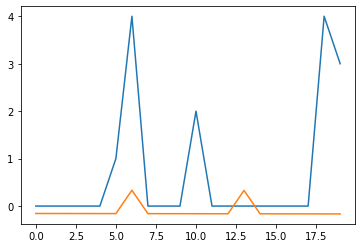

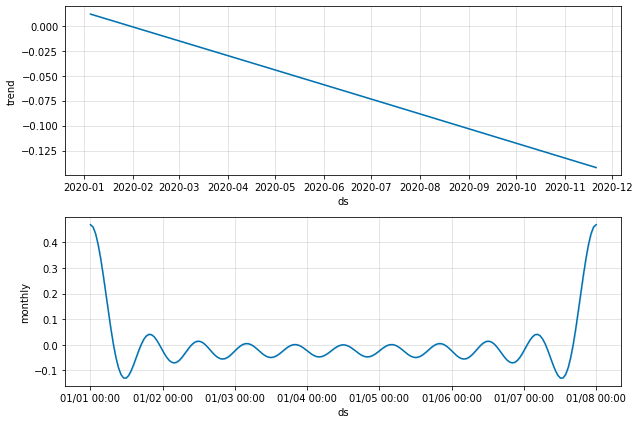

In [ ]:
print(r2_score(list(test['y']), list(forecast.loc[train_data.shape[0]:,'yhat'] )))
plt.plot(list(test['y']))
plt.plot(list(forecast.loc[train_data.shape[0]:,'yhat'] ))
fig2 = m.plot_components(forecast)
plt.show()

### DeepAR

In [ ]:
test_ds

NameError: ignored

In [ ]:
from gluonts.dataset.common import ListDataset
start = pd.Timestamp("01-05-2020", freq="H")
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': y.loc[train.shape[0]:,'y'], 'start': start}], freq='H')
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': y['y'], 'start': start}], freq='H')

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx
import numpy as np
np.random.seed(7)
mx.random.seed(7)
estimator = DeepAREstimator(prediction_length=test.shape[0], context_length=100, freq='H', trainer=Trainer(ctx="cpu", # remove if running on windows
                                                                                                epochs=5,learning_rate=1e-3,num_batches_per_epoch=100) 
)
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:20<00:00,  4.90it/s, epoch=5/5, avg_epoch_loss=67.8]


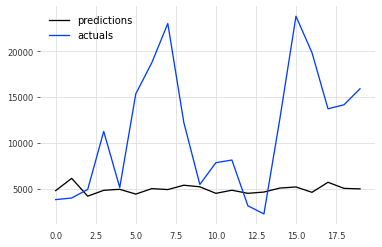

7004.1826


In [ ]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)
plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-20:])
plt.legend(['predictions', 'actuals'])
plt.show()
print(mean_absolute_error(list(test_ds)[0]['target'][-20:], predictions))

In [ ]:
list(train_ds)[0]['target']

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 170.01,   0.  ,
         0.  , 120.02,   0.  ,   0.  ,  44.99,   0.  ,   0.  , 255.96,
         0.  , 480.01,   0.  ,  24.99,   0.  ,   0.  , 529.96, 128.99,
         0.  ,   0.  , 200.01,   0.  ,   0.  ,   0.  , 160.04,   0.  ,
       139.99,   0.  ,  80.02,   0.  ,  92.99, 240.04, 220.01,   0.  ,
        80.02,   0.  ,   0.  ,   0.  ,  80.02, 189.99,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  , 145.01, 110.02,  39.99,  85.02, 225.04,
        79.99,  80.02, 119.99,   0.  , 160.04, 360.02,   0.  ,   0.  ,
       450.02, 380.06,   0.  ,   0.  ,  12.  ,   0.  , 229.99,   0.  ,
       305.04,   0.  ,  30.  ,   0.  ,   0.  ,   0.  ,  45.  ,   0.  ,
        24.99, 119.96, 199.01,   0.  ,   0.  ,   0.  , 120.  ,  80.02,
         0.  , 189.98,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
        79.99,   0.  , 228.99, 210.01, 414.96, 394.97, 109.99, 109.99,
       469.96,   0.  ,   0.  ,  54.99, 304.98, 229.98,  79.99, 429.97,
      

### EDM

In [9]:
import pyEDM

In [29]:
y

,ds,y
0,2020-01-05,587.32
1,2020-01-12,6578.59
2,2020-01-19,2679.40
3,2020-01-26,1042.70
4,2020-02-02,2082.22
...,...,...
59,2021-02-21,31493.00
60,2021-02-28,5582.31
61,2021-03-07,20113.51
62,2021-03-14,10963.98


In [30]:
y = y[["ds","y"]]
y.columns = ["Time", "Revenue"]
y.Time = list(range(1,df.shape[0]+1,1))

In [31]:
y=y+0.0001

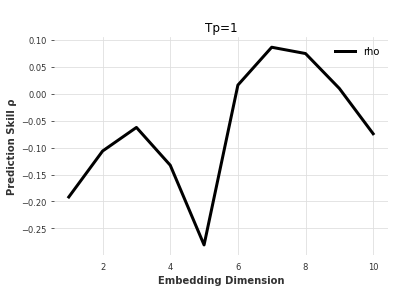

{'MAE': 3582.196723136995, 'RMSE': 4348.246543215439, 'rho': 0.743445097637053}


<AxesSubplot:>

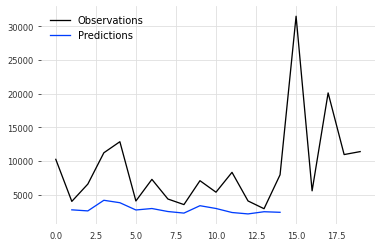

In [33]:
aaa=pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue",showPlot=True)
maxE = aaa.rho.max()
selectedE=aaa[aaa.rho==maxE]['E']
#bbb=pyEDM.PredictInterval(dataFrame = y,lib="1 44", pred="45 64", columns="Revenue", E=selectedE, showPlot=False)
simplex_pred = pyEDM.Simplex(dataFrame = y,lib="1 44", pred="45 64", E = 7, columns="Revenue",Tp=1,tau=1)
print(pyEDM.ComputeError(simplex_pred['Observations'],simplex_pred['Predictions']))
simplex_pred[['Observations', 'Predictions']].plot()

In [ ]:
simplex_pred

In [ ]:
pip install skedm

In [ ]:
df.VlTotalBruto

In [ ]:
pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue",showPlot=True)

In [105]:
#import skedm.data as data

X = data.lorenz(sz=10000)[:,0] #only going to use the x values from the lorenz system
X = df.VlTotalBruto

In [106]:
y = df.reset_index(drop=False)
y.columns = ['ds', 'y']
y = y[["ds","y"]]
y.columns = ["Time", "Revenue"]
y.Time = list(range(1,df.shape[0]+1,1))

In [107]:
import skedm as edm
import pyEDM
X = df.VlTotalBruto
E = edm.Embed(X) #initiate the class

max_lag = 20
mi = E.mutual_information(max_lag)
mi = pd.DataFrame(mi)
mi['lag'] = range(0,20,1)
mi.columns = ["mi", "lag"]
maxMI = mi.mi.max()
selectedMI=mi[mi.mi==maxMI]['lag']

In [122]:
aaa=pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue",showPlot=False)
maxE = aaa.rho.max()
selectedE=aaa[aaa.rho==maxE]['E']

In [128]:
lag = int(selectedMI)
embed = int(selectedE)
predict = 20 #predicting out to double to lag
X,y = E.embed_vectors_1d(lag,embed,predict)

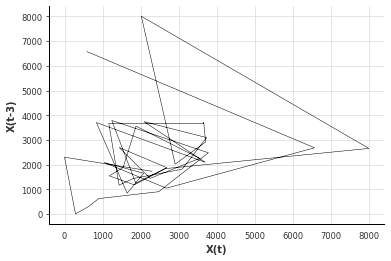

In [129]:
##fig,ax = plt.subplots()
#ax.plot(X[:,0],X[:,1],linewidth=.5)
#ax.set_xlabel('X(t)')
#ax.set_ylabel('X(t-3)')
#sns.despine()

In [130]:
#split it into training and testing sets
train_len = int(.70*len(X))
Xtrain = X[0:train_len]
ytrain = y[0:train_len]
Xtest = X[train_len:]
ytest = y[train_len:]

weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [171]:
M.fit(Xtrain, ytrain) #fit the data (rebuilding the attractor)

nn_list = [20]
ypred = M.predict(Xtest,nn_list)
ypred = pd.DataFrame(ypred[0])
ypred.mean(axis=0)
ypred = ypred.mean(axis=0)

In [185]:
mean_absolute_percentage_error(list(df.VlTotalBruto[44:]),list(ypred))


55.717429386499376

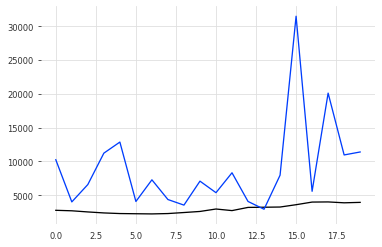

In [188]:
plt.plot(ypred)
plt.plot(list(df.VlTotalBruto[44:]))

In [222]:
par={}
erro={}
par_croston={}
erro_croston={}
erro_prophet={}
erro_EDM = {}
erro_novos = {}
models = [NaiveDrift(),
          ExponentialSmoothing(),
          Theta(),
          FFT(trend='poly',trend_poly_degree = 3)]


#for j, i in zip(tqdm (range(0, 7),desc="Processando Fornecedor", ascii=False, ncols=75), tqdm (range(0,len(dat_aux.iloc[j,0])),desc="Processando Id Oriduto", ascii=False, ncols=75)):

for j in tqdm (range(0, 1),desc="Processando Fornecedor", ascii=False, ncols=75):
  
    try:
   # Selecionando os dados para ajustar os modelos
         filter1 = df_original["DsDivisaoFornecedor"]==dat_aux.index[j]
         #filter1 = df_original["DsDivisaoFornecedor"]=='SAINT GOBAIN DO BRASIL PRODUTOS IND'
         df_0 = df_original[filter1]
         df = df_0.groupby(['Semanas'])[['VlTotalBruto']].sum()
         we = pd.DataFrame(list(range(1,65,1)))
         we.columns=['Semanas']
         we.index=we.Semanas
         df = pd.concat([df, we], axis=1)
         df=df['VlTotalBruto']
         df.index = pd.DataFrame(pd.date_range('2020-01-05', freq='7D', periods=64), columns=['date']).iloc[:,0]
         df = pd.DataFrame(df).fillna(0)

      # Substituindo outliers
         z = np.abs(stats.zscore(df.VlTotalBruto))
         median=df.VlTotalBruto.median()
         df["VlTotalBruto"] = np.where(z>3, median, df["VlTotalBruto"])

      # Sets de treino e teste
         train_len = int(df.shape[0] * 0.7)
         train_data, test_data = df[:train_len], df[train_len:]

      # Ajustando AutoArima
         stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
   
      # Armazenando resultados AutoArima
         sentence = [str(dat_aux.index[j])]
         sentence = '-'.join(sentence)
         aux = stepwise_fit.get_params()
         par[sentence]=aux
         forecasts = stepwise_fit.predict(test_data.shape[0])
         mmae = mean_absolute_percentage_error(list(list(test_data.VlTotalBruto)), list(forecasts))
         erro[sentence]=mmae
         erro
  
      # Ajustando modelo Croston
         croston_pred = croston.fit_croston(df+0.000001,test_data.shape[0],'original')

      # Armazenando resultados Croston
         par_croston[sentence] = croston_pred
         erro_croston[sentence] = mean_absolute_percentage_error(list(test_data.VlTotalBruto), croston_pred['croston_forecast'])

      # O modelo profet só funciona com duas colunas
         y = df.reset_index(drop=False)
         y.columns = ['ds', 'y']
         #y['floor'] = 0
         #y['cap'] = 200000
         train = y.iloc[:train_data.shape[0],:]
         test = y.iloc[train_data.shape[0]:,:]

      #Ajustando modelo Prophet
         m = Prophet(weekly_seasonality = True,
                     yearly_seasonality = False,
                     daily_seasonality = False)
         m.fit(train)
         future = m.make_future_dataframe(periods=len(test))
         future['ds'] = pd.to_datetime(future['ds']).dt.date
         forecast = m.predict(future)
         one=test['y']
         twi=list(forecast.loc[:test_data.shape[0]-1,'yhat'])
         erro_prophet[sentence] = mean_absolute_percentage_error(list(one),list(twi))
         

         # O EDM agora, preparando o imput
         y = y[["ds","y"]]
         y.columns = ["Time", "Revenue"]
         y.Time = list(range(1,df.shape[0]+1,1))
         aaa=pyEDM.EmbedDimension(dataFrame = y, lib="1 44", pred="45 64", columns="Revenue",target = "Revenue",showPlot=False)
         maxE = aaa.rho.max()
         selectedE=aaa[aaa.rho==maxE]['E']
         X = y.Revenue
         E = edm.Embed(X) #initiate the class
         max_lag = 20
         mi = E.mutual_information(max_lag)
         mi = pd.DataFrame(mi)
         mi['lag'] = range(0,20,1)
         mi.columns = ["mi", "lag"]
         maxMI = mi.mi.max()
         selectedMI=mi[mi.mi==maxMI]['lag']
         lag = int(selectedMI)
         embed = int(selectedE)
         predict = 20 #predicting out to double to lag
         X,y = E.embed_vectors_1d(lag,embed,predict)
         #split it into training and testing sets
         train_len = int(.70*len(X))
         Xtrain = X[0:train_len]
         ytrain = y[0:train_len]
         Xtest = X[train_len:]
         ytest = y[train_len:]

         weights = 'distance' #use a distance weighting for the near neighbors
         M = edm.Regression(weights) # initiate the nonlinear forecasting class
         M.fit(Xtrain, ytrain) #fit the data (rebuilding the attractor)

         nn_list = [20]
         ypred = M.predict(Xtest,nn_list)
         ypred = pd.DataFrame(ypred[0])
         ypred.mean(axis=0)
         ypred = ypred.mean(axis=0)
         erro_EDM[sentence] = mean_absolute_percentage_error(list(df.VlTotalBruto[44:]),list(ypred))

         # PAra Naive, Prophet, exponential smothing, theta, FFT
         series = TimeSeries.from_dataframe(df.reset_index(), 'date', 'VlTotalBruto')
         train2, val = series.split_after(0.7)
         for model in models:
               model.fit(train2+0.00000001)
               pred_val = model.predict(len(val))
               erro_novos[sentence] = str(mape(pred_val, val))


         
    except:
      pass   

#pd.DataFrame.from_dict(erro_prophet,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/prophet.csv')
#pd.DataFrame.from_dict(erro_croston,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/croston.csv')
#pd.DataFrame.from_dict(erro,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/arima.csv')
#pd.DataFrame.from_dict(erro_EDM,orient='index').to_csv('/content/drive/MyDrive/JOB-Martins/EDM.csv')
print('Cmplete')


Processando Fornecedor: 100%|████████████████| 1/1 [00:26<00:00, 26.09s/it]

Cmplete


In [224]:

erro,erro_croston,erro_prophet,erro_EDM,erro_novos

({'3M DO BRASIL LTDA': 117.64826196347087},
 {'3M DO BRASIL LTDA': 80.63675939470585},
 {},
 {},
 {})

In [203]:
from darts import TimeSeries
from darts.metrics import mape
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)
import skedm as edm

In [214]:
TimeSeries.from_dataframe(df.reset_index(), 'date', 'VlTotalBruto')

<TimeSeries (DataArray) (date: 64, component: 1, sample: 1)>
array([[[   0.  ]],

       [[1548.46]],

       [[1091.21]],

       [[ 565.64]],

       [[ 451.2 ]],

       [[2381.3 ]],

       [[1984.23]],

       [[ 759.7 ]],

       [[1639.15]],

       [[3864.55]],

...

       [[2087.17]],

       [[ 566.12]],

       [[1978.65]],

       [[2378.41]],

       [[3057.55]],

       [[5985.98]],

       [[1928.65]],

       [[ 504.62]],

       [[2147.24]],

       [[1483.13]]])
Coordinates:
  * date       (date) datetime64[ns] 2020-01-05 2020-01-12 ... 2021-03-21
  * component  (component) object 'VlTotalBruto'
Dimensions without coordinates: sample